### Loading libraries

In [1]:
library(vegan)
library(phyloseq)
library(ranacapa)
library(ape)
library(ggplot2)
library(ggpubr)
library(reshape2)
library(ggnewscale)

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4


Attaching package: ‘ggpubr’


The following object is masked from ‘package:ape’:

    rotate




In [2]:
dir.create(file.path('../../results/figures'), showWarnings = FALSE)
dir.create(file.path('../../results/figures', 'figure3'), showWarnings = FALSE)
dir.create(file.path('../../results/figures', 'supplementary_figure2'), showWarnings = FALSE)

### Loading data

In [3]:
# load phyloseq object
ps <- readRDS('../../data/phyloseq/nohost_asv/phyloseq.rds')
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 17022 taxa and 199 samples ]
sample_data() Sample Data:       [ 199 samples by 57 sample variables ]
tax_table()   Taxonomy Table:    [ 17022 taxa by 7 taxonomic ranks ]

In [4]:
set.seed(295) # setting seed to replicate the randomized rarefraction
# rarefy phyloseq object
ps_rarefied <- rarefy_even_depth(ps, 1e+05)
ps_rarefied

You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`


...

3 samples removedbecause they contained fewer reads than `sample.size`.

Up to first five removed samples are: 


sample_044sample_063sample_168

...

2379OTUs were removed because they are no longer 
present in any sample after random subsampling


...



phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14643 taxa and 196 samples ]
sample_data() Sample Data:       [ 196 samples by 57 sample variables ]
tax_table()   Taxonomy Table:    [ 14643 taxa by 7 taxonomic ranks ]

In [5]:
# create an ASV name containing family, genus, and species levels
tax_data <- data.frame(tax_table(ps_rarefied))
tax_data$name <- apply(tax_data, 1, function(x){paste(x[c('Family', 'Genus', 'Species')], collapse=';')})

### Identify ASV presence odds for group of samples with STH Negative status at the baseline

In [7]:
# find ids of people who participated in the follow-up study and had a negative STH status at the baseline
onlydewormed_ids <- sample_data(ps_rarefied)[(sample_data(ps_rarefied)[['collection_timepoint']] == 'follow-up')&(sample_data(ps_rarefied)[['subject_eggcountAnySTHs_baseline']] == 0),]$host_subject_id
# select only samples from subjects participated in the follow-up study
ps_STHNegative <- subset_samples(ps_rarefied, host_subject_id %in% onlydewormed_ids)
ps_rarefied_onlywithdewormed <- ps_STHNegative
# check if the size of the table matches to our expectation
length(onlydewormed_ids)*2 == nsamples(ps_rarefied_onlywithdewormed)

[1] TRUE

In [8]:
# select only samples from the baseline study
ps_rarefied_onlywithdewormed_baseline <- subset_samples(ps_rarefied_onlywithdewormed, 
                                                       collection_timepoint == 'baseline')
# retrieve ASV counts table
otu_data_baseline <- otu_table(ps_rarefied_onlywithdewormed_baseline)
# transform the counts table to a binary table: assign 1 to all counts larger than zero
otu_data_baseline[otu_data_baseline > 0] <- 1
# add two dummy rows with all taxa present (a row of 1s) and all taxa absent (a row of 0s)
otu_data_baseline <- rbind(otu_data_baseline, 
                           t(data.frame(sample_present=rep(1, dim(otu_data_baseline)[2]), 
                           sample_absent=rep(0, dim(otu_data_baseline)[2]))))

In [9]:
# select only samples from the follow-up study
ps_rarefied_onlywithdewormed_followup <- subset_samples(ps_rarefied_onlywithdewormed, 
                                                       collection_timepoint == 'follow-up')
# retrieve ASV counts table
otu_data_followup <- otu_table(ps_rarefied_onlywithdewormed_followup)
# transform the counts table to a binary table: assign 1 to all counts larger than zero
otu_data_followup[otu_data_followup > 0] <- 1
# add two dummy rows with all taxa present (a row of 1s) and all taxa absent (a row of 0s)
otu_data_followup <- rbind(otu_data_followup, 
 t(data.frame(sample_present=rep(1, dim(otu_data_followup)[2]), 
              sample_absent=rep(0, dim(otu_data_followup)[2]))))

In [10]:
# count ASV odds of being present
genera <- colnames(otu_data_followup) # retrieve all ASV
odds_STHNegative <- lapply(genera, function(taxa){        # for each ASV
    # create a prescence/absence table
    counts_df <-  rbind(table(otu_data_baseline[, taxa]), # count presence/absence of the given ASV in a baseline cohort
                        table(otu_data_followup[, taxa])) # count presence/absence of the given ASV in a follow-up cohort
    counts_df <- counts_df-1 # distract the counts of dummy variables
    if (counts_df[1, 2]+counts_df[2, 2] > 3) { # do not consider low represented ASVs 
                                               # (ASVs present in a total of 3 or less samples)
        # return a table with the information about ASV, odds of presence and amounts of prescence in each group
        return(data.frame(genera=taxa, 
                          odds=counts_df[1, 2]/counts_df[2, 2], 
                          values=paste(counts_df[1, 2], counts_df[2, 2], collapse=';')))
    }
})
odds_STHNegative <- do.call('rbind', odds_STHNegative) # concatenate rows
odds_STHNegative$genera_name <- tax_data[odds_STHNegative$genera, 'name'] # join ASV names (family, genus, species)

### Identify ASV presence odds for group of samples with STH Positive status at the baseline

In [11]:
# find ids of people who participated in the follow-up study and had a positive STH status at the baseline
onlydewormed_ids <- sample_data(ps_rarefied)[(sample_data(ps_rarefied)[['collection_timepoint']] == 'follow-up')&(sample_data(ps_rarefied)[['subject_eggcountAnySTHs_baseline']] > 0),]$host_subject_id
# select only samples from subjects participated in the follow-up study
ps_STHPositive <- subset_samples(ps_rarefied, host_subject_id %in% onlydewormed_ids)
ps_rarefied_onlywithdewormed <- ps_STHPositive
# check if the size of the table matches to our expectation
length(onlydewormed_ids)*2 == nsamples(ps_rarefied_onlywithdewormed)

[1] TRUE

In [12]:
# select only samples from the baseline study
ps_rarefied_onlywithdewormed_baseline <- subset_samples(ps_rarefied_onlywithdewormed, 
                                                       collection_timepoint == 'baseline')
# retrieve ASV counts table
otu_data_baseline <- otu_table(ps_rarefied_onlywithdewormed_baseline)
# transform the counts table to a binary table: assign 1 to all counts larger than zero
otu_data_baseline[otu_data_baseline > 0] <- 1
# add two dummy rows with all taxa present (a row of 1s) and all taxa absent (a row of 0s)
otu_data_baseline <- rbind(otu_data_baseline, 
 t(data.frame(sample_present=rep(1, dim(otu_data_baseline)[2]), 
             sample_absent=rep(0, dim(otu_data_baseline)[2]))))

In [13]:
# select only samples from the follow-up study
ps_rarefied_onlywithdewormed_followup <- subset_samples(ps_rarefied_onlywithdewormed, 
                                                       collection_timepoint == 'follow-up')
# retrieve ASV counts table
otu_data_followup <- otu_table(ps_rarefied_onlywithdewormed_followup)
# transform the counts table to a binary table: assign 1 to all counts larger than zero
otu_data_followup[otu_data_followup > 0] <- 1
# add two dummy rows with all taxa present (a row of 1s) and all taxa absent (a row of 0s)
otu_data_followup <- rbind(otu_data_followup, 
 t(data.frame(sample_present=rep(1, dim(otu_data_followup)[2]), 
              sample_absent=rep(0, dim(otu_data_followup)[2]))))

In [14]:
# count ASV odds of being present
genera <- colnames(otu_data_followup)  # retrieve all ASV
odds_STHPositive <- lapply(genera, function(taxa){ # for each ASV
    # create a prescence/absence table
    counts_df <-  rbind(table(otu_data_baseline[, taxa]), # count presence/absence of the given ASV in a baseline cohort
                        table(otu_data_followup[, taxa])) # count presence/absence of the given ASV in a follow-up cohort
    counts_df <- counts_df-1 # distract the counts of dummy variables
    if (counts_df[1, 2]+counts_df[2, 2] > 3) { # do not consider low represented ASVs 
                                               # (ASVs present in a total of 3 or less samples)
        # return a table with the information about ASV, odds of presence and amounts of prescence in each group
        return(data.frame(genera=taxa, odds=counts_df[1, 2]/counts_df[2, 2], 
                          values=paste(counts_df[1, 2], counts_df[2, 2], collapse=';')))
    }
})
odds_STHPositive <- do.call('rbind', odds_STHPositive) # concatenate rows
odds_STHPositive$genera_name <- tax_data[odds_STHPositive$genera, 'name'] # join ASV names (family, genus, species)

### Identify a threshold for significantly large odds

In [15]:
# combine odds for computed for postive and negative STH status (at the baseline) groups 
odds <- rbind(odds_STHNegative, odds_STHPositive)
# calculate p-values
odds$pvalue <- lapply(odds$odds, function(x){1-sum(x>odds$odds)/length(odds$odds)})
# calculate an odds threshold for the significant p-value
threshold <- min(odds[odds$pvalue < 0.05, 'odds'])

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 58 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 58 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


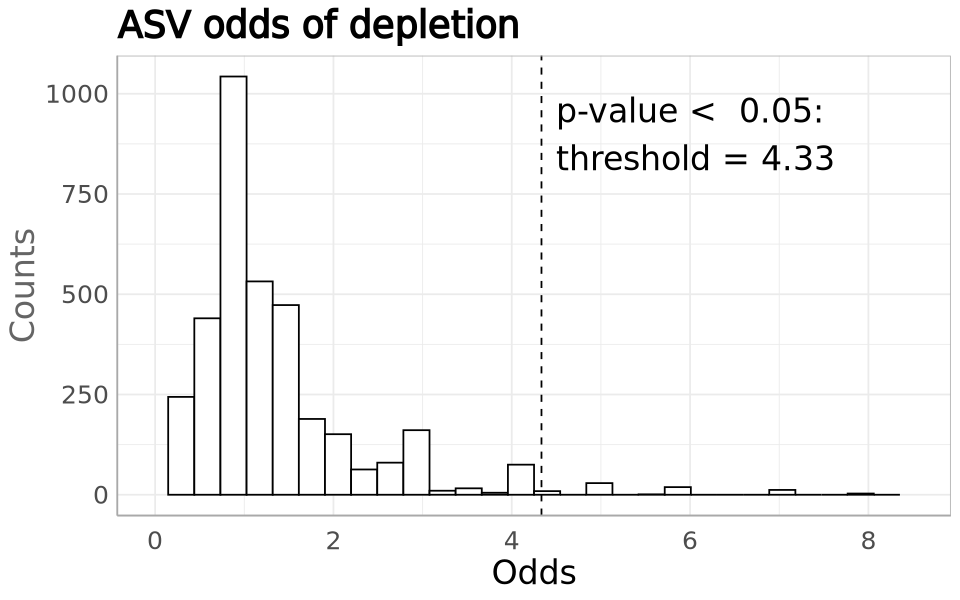

In [16]:
# plot
# set a figure size
width = 8
height = 5
options(repr.plot.width = width, repr.plot.height = height)

# plot
p <- ggplot(odds, aes(x=odds)) + 
   geom_histogram(color="black", fill="white") +
   geom_vline(xintercept = threshold, linetype="dashed") +
   annotate("text", x=6, y=900, 
            label= paste0("p-value <  0.05:\n threshold = ", round(threshold, 2)), size=7) + 
   xlim(0, 8.5) +
   labs(x = "Odds", y = "Counts", title = 'ASV odds of depletion') +
   theme_minimal() +
   theme(axis.text=element_text(size=15),
        axis.title=element_text(size=20, face="plain"), 
        plot.title=element_text(size=22, face="bold"),
        plot.subtitle=element_text(size=22, face="plain"),
        strip.text = element_text(size = 25, hjust=0, color='#656565'), 
        axis.title.y = element_text(color='#656565', face='plain'),
        axis.ticks.x=element_blank(),
        axis.ticks.length.x.bottom=unit(0.5, "lines"),
        text = element_text(size = 25, face="plain"), 
        axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
        axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
        panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
        panel.spacing.x = unit(2, "lines")
       ) 

k = 0.3
ggsave(file=file.path('../../results/figures', 'supplementary_figure2', 'histogram.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)
p

### Identify ASVs that present significantly less frequent in the follow-up cohort than in the baseline cohort

In [17]:
# select such vanished ASVs among samples with STH negative status a the baseline
odds_selected <- odds_STHNegative[odds_STHNegative$odds >= threshold, ]
# calculate the amounts of vanished ASVs assigned to each Family
df_bar <- data.frame(table(tax_data[odds_selected$genera, 'Family']))
colnames(df_bar) <- c('Family', 'Counts') # rename columns
# select only those ASVs which are represented by more than 1 vanished ASV
df_bar_trimmed_STHNegative <- df_bar[df_bar$Counts > 1, ]
# rename rows with numbers 1 to length(df_bar_trimmed_STHNegative)
row.names(df_bar_trimmed_STHNegative) <- c(1:dim(df_bar_trimmed_STHNegative)[1])
df_bar_trimmed_STHNegative$Family <- as.character(df_bar_trimmed_STHNegative$Family) # defactorize
# assign the corresponding Phylum
df_bar_trimmed_STHNegative$Phylum <- unlist(as.vector(lapply(df_bar_trimmed_STHNegative$Family, 
                                                 function(x) tax_data[tax_data$Family == x, 'Phylum'][1])))
# create a new Family called 'Others', containing a amount of familied represented by one ASV
df_bar_trimmed_STHNegative[dim(df_bar_trimmed_STHNegative)[1]+1, 'Counts'] <- sum(df_bar$Counts > 1)
df_bar_trimmed_STHNegative[dim(df_bar_trimmed_STHNegative)[1], 'Family'] <- 'Others'
df_bar_trimmed_STHNegative[dim(df_bar_trimmed_STHNegative)[1], 'Phylum'] <- 'Others'
# assign an STH negative group to all counts in the data frame 
df_bar_trimmed_STHNegative$group <- 'STHNegative'

In [18]:
# select such vanished ASVs among samples with STH positive status a the baseline
odds_selected <- odds_STHPositive[odds_STHPositive$odds >= threshold, ]
# calculate the amounts of vanished ASVs assigned to each Family
df_bar <- data.frame(table(tax_data[odds_selected$genera, 'Family']))
colnames(df_bar) <- c('Family', 'Counts') # rename columns
# select only those ASVs which are represented by more than 1 vanished ASV
df_bar_trimmed_STHPositive <- df_bar[df_bar$Counts > 1, ]
# rename rows with numbers 1 to length(df_bar_trimmed_STHNegative)
row.names(df_bar_trimmed_STHPositive) <- c(1:dim(df_bar_trimmed_STHPositive)[1])
df_bar_trimmed_STHPositive$Family <- as.character(df_bar_trimmed_STHPositive$Family) # defactorize
# assign the corresponding Phylum
df_bar_trimmed_STHPositive$Phylum <- unlist(as.vector(lapply(df_bar_trimmed_STHPositive$Family, 
                                                 function(x) tax_data[tax_data$Family == x, 'Phylum'][1])))
# create a new Family called 'Others', containing a amount of familied represented by one ASV
df_bar_trimmed_STHPositive[dim(df_bar_trimmed_STHPositive)[1]+1, 'Counts'] <- sum(df_bar$Counts > 1)
df_bar_trimmed_STHPositive[dim(df_bar_trimmed_STHPositive)[1], 'Family'] <- 'Others'
df_bar_trimmed_STHPositive[dim(df_bar_trimmed_STHPositive)[1], 'Phylum'] <- 'Others'
# assign an STH positive group to all counts in the data frame 
df_bar_trimmed_STHPositive$group <- 'STHPositive'

In [19]:
# combine Family counts into one table
df_bar_trimmed <- rbind(df_bar_trimmed_STHNegative, df_bar_trimmed_STHPositive)
# create a column of a counts order by Phylum
df_bar_trimmed$order <- order(df_bar_trimmed$Phylum)
# eliminate Phylum only present in one group
df_bar_trimmed[dim(df_bar_trimmed)[1], 'order'] <- max(df_bar_trimmed$order) + 1
# # order a data frame
df_bar_trimmed <- df_bar_trimmed[df_bar_trimmed$order, ]
# # eliminate all NA families
df_bar_trimmed <- df_bar_trimmed[!is.na(df_bar_trimmed$Family), ]
# # factorize a family column
df_bar_trimmed$Family <- factor(df_bar_trimmed$Family, levels=unique(df_bar_trimmed$Family))
df_bar_trimmed

,Family,Counts,Phylum,group,order
,<fct>,<int>,<chr>,<chr>,<dbl>
1,Bacteroidaceae,3,Bacteroidetes,STHNegative,1
7,Prevotellaceae,6,Bacteroidetes,STHNegative,2
10,Tannerellaceae,2,Bacteroidetes,STHNegative,5
12,Bacteroidaceae,6,Bacteroidetes,STHPositive,9
15,Marinifilaceae,3,Bacteroidetes,STHPositive,17
16,Prevotellaceae,4,Bacteroidetes,STHPositive,11
2,Clostridiaceae_1,2,Firmicutes,STHNegative,7
3,Clostridiales_vadinBB60_group,9,Firmicutes,STHNegative,10
4,Erysipelotrichaceae,2,Firmicutes,STHNegative,12


In [20]:
# To create a "stacked" barplot add the total Phylum counts to the first Family counts of the next Phylum
# create row names
row.names(df_bar_trimmed) <- paste(df_bar_trimmed$Family, df_bar_trimmed$group, sep=';')
# 1. add a total counts of all Phylums except 'Others' to the Others'coutns
#    to ensure them being on top of the plot
# select all rows but Others phylum
add_counts <- dplyr::filter(df_bar_trimmed, df_bar_trimmed$Phylum != "Others")
# calculate the total counts of non-Others Phylum
add_counts <- aggregate(Counts ~ group, add_counts, sum)
# ensure an order by group
add_counts <- add_counts[order(add_counts$group), ]
# add counts to the Others phylum
df_bar_trimmed[c('Others;STHNegative', 'Others;STHPositive'), 'Counts'] <- df_bar_trimmed[c('Others;STHNegative', 'Others;STHPositive'), 'Counts']+add_counts$Counts

# add Firmicutes Phylum counts to the first Families of the Bacteroides family 
# in STHNegative and STHPositive groups
# select Firmicutes Phylum counts
add_counts <- dplyr::filter(df_bar_trimmed, df_bar_trimmed$Phylum == "Firmicutes")
# calculate the total counts of Firmicutes Phylum
add_counts <- aggregate(Counts ~ group, add_counts, sum)
# ensure an order by group
add_counts <- add_counts[order(add_counts$group), ]
# add counts to the first Families of the Bacteroides family 
df_bar_trimmed[c('Tannerellaceae;STHNegative', 'Prevotellaceae;STHPositive'), 'Counts'] <- df_bar_trimmed[c('Tannerellaceae;STHNegative', 'Prevotellaceae;STHPositive'), 'Counts']+add_counts$Counts

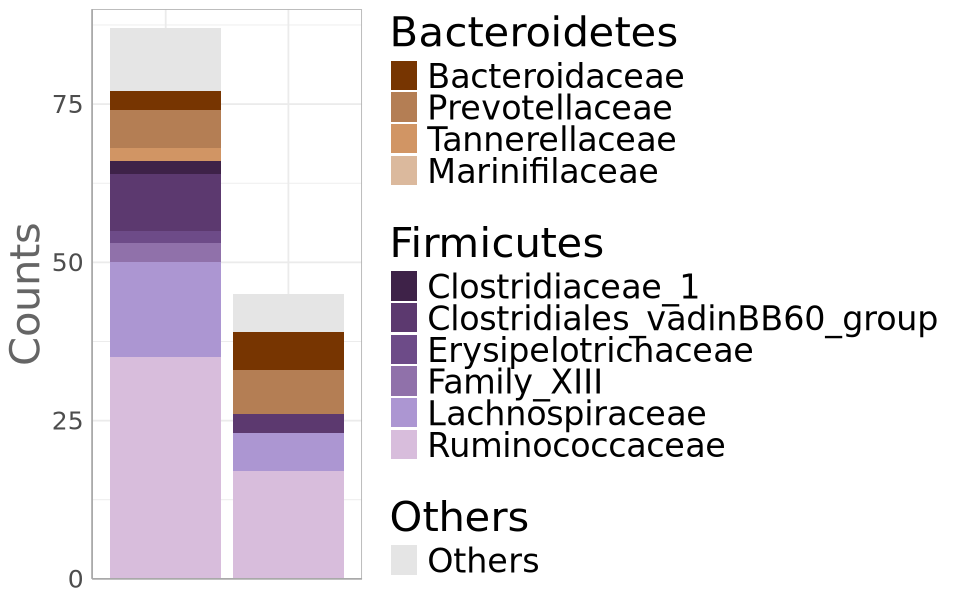

In [21]:
# plot
# set a plot size
width = 8
height = 5
options(repr.plot.width = width, repr.plot.height = height)

# plot manually stacked barplots
p <- ggplot(data=df_bar_trimmed) +
      geom_bar(data = ~ dplyr::filter(., Phylum == "Others") %>% dplyr::rename(Others = Family), 
              mapping = aes(x=group, y=Counts, fill=Others), 
              stat="identity") +
      scale_fill_manual(values=c('#e5e5e5', '#e5e5e5'))+
      new_scale_fill() +
      geom_bar(data = ~ dplyr::filter(., Phylum == "Bacteroidetes") %>% dplyr::rename(Bacteroidetes = Family),  
              mapping = aes(x=group, y=Counts, fill=Bacteroidetes), 
              stat="identity") +
      scale_fill_manual(values=rev(c('#dbb99d', '#d19564', '#b47e54', '#773501')))+
      new_scale_fill() +
      geom_bar(data = ~ dplyr::filter(., Phylum == "Firmicutes") %>% dplyr::rename(Firmicutes = Family),  
              mapping = aes(x=group, y=Counts, fill=Firmicutes), 
              stat="identity") +
      scale_fill_manual(values=rev(c('#d8bddc',  '#ac96d2', '#9071aa', '#6d4b88', '#5c396f', '#3e2248')))+
      new_scale_fill() +
      scale_y_continuous(limits = c(0, 90), expand = c(0,0)) +
      theme_minimal() + 
      theme(axis.text=element_text(size=15),
            axis.title=element_text(size=25, face="plain"), 
            plot.title=element_text(size=25, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            strip.text = element_text(size = 25, hjust=0, color='#656565'), 
            axis.text.x.bottom = element_blank(),
            axis.text.x = element_blank(),
            axis.title.x = element_blank(),
            axis.title.y = element_text(color='#656565', face='plain'),
            axis.ticks.x=element_blank(), 
            axis.ticks.length.x.bottom=unit(0.5, "lines"),
            text = element_text(size = 25, face="plain"), 
            axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
            axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
            panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
            panel.spacing.x = unit(2, "lines")
           ) 
k = 0.3
ggsave(file=file.path('../../results/figures', 'figure3', 'stacked_plot.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)
p